# Transformer activity

In this activity, you will make a transformer model in the PyTorch deep learning package to perform classification of time-series biomedical sensor data for identifying freezing of gait in Parkinson's patients. There will also be a demo section on how to use pre-trained transformers model for natural language processing (NLP) applications using the HuggingFace 🤗 Transformers library.

There are 3 main tasks for you to complete the example, running the actual training is optional. Cells have clearly marked `# TODO` and `#####` comments for you to insert your code between. Variables assigned to `None` should keep the same name but assigned to their proper implementation.

1. Complete the implementation of the sinusoidal position embeddings
2. Complete the transformer implementation by creating a transformer encoder layer from `torch.nn`
3. Add in GPU support to the training loop
4. Train the models for 5 epochs (optional)
4. Review the HuggingFace transformers code (optional)

# Build a transformer model

Although transformers are a very hot topic right now in deep learning, they're definitly not going to solve all of your deep learning problems!  
- On smaller datasets and problems, training a transformer from scratch does not always result in better performance compared to CNNs and RNNs
- Transformers need a lot of data to have optimal performance
- Processing longer sequence lengths requires $\mathcal{O}(N^2)$ memory. We don't typically use larger than $N = 512$ for most problems, keeping under $N = 128$ if you can will reduce memory usage and improve runtimes
- With the added complexity of the architecture, you almost certainly want to train using a GPU to have a reasonable workflow

For this activity, we will be building a small* transformer model to process some biomedical sensor data collected for detecting freezing of gait walking patterns in patients with Parkinson's disease. The raw data is [available here](https://data.mendeley.com/datasets/r8gmbtv7w2/3). The data has already been normalized and segmented into windows of length $N = 256$. The feature dimension is 30, which includes accelerometer and gyroscope sensor data from IMUs placed on the leg and arm, and EMG signals from leg muscles. There are 10,000 training examples and 1000 test examples. Note that the dataset is ~600 MB, which might take a while to download and upload to Google Colab. You don't need to actually download the dataset to do the tutorial activity, but if you want to run the training yourself, then you can do that at a later time.

(*small by transformer scales, this model is around 600k parameters, compared to 100s of billions with state-of-the-art transformers like GPT-3)

Dataset citation:

Li, Hantao (2021), “Multimodal Dataset of Freezing of Gait in Parkinson's Disease”, Mendeley Data, V3, doi: 10.17632/r8gmbtv7w2.3


In [1]:
# TODO: Run this cell to import relevant packages

import torch  # Main torch import for torch tensors (arrays)
import torch.nn as nn  # Neural network module for building deep learning models
import torch.nn.functional as F  # Functional module, includes activation functions
import torch.optim as optim  # Optimization module

from typing import Optional
from sklearn.metrics import accuracy_score  # Computing accuracy metric
import pickle
import numpy as np

## 1. Complete the sinusoidal position embeddings

Complete the formula for the position encoding (the argument to the sine and cosine). The odd dimension indices get sine features, while the even dimension indices get cosine features. $D$ is the embedding dimension, and $N$ is the sequence length.

$\mathbf{p}[k, 2i] = sin(k / 10000^{2i / D}); \ i = 1,...,D//2; \ k = 1,...,N$

$\mathbf{p}[k, 2i+1] = cos(k / 10000^{2i / D}); \ i = 1,...,D//2; \ k = 1,...,N$

In [2]:
class SinusoidalPositionalEmbedding(nn.Embedding):
    """This module produces sinusoidal positional embeddings of any length."""
    def __init__(self, num_positions: int, embedding_dim: int, padding_idx: Optional[int] = None) -> None:
        super().__init__(num_positions, embedding_dim)
        self.weight = self._init_weight(self.weight)

    @staticmethod
    def _init_weight(out: nn.Parameter) -> nn.Parameter:
        """
        Interleaved sine and cosine position embeddings
        """
        out.requires_grad = False
        out.detach_()
        
        N, D = out.shape

        ## TODO: Create a N x D//2 array of position encodings (argument to the sine/cosine)
        
        position_enc = None
        #####

        out[:, 0::2] = torch.FloatTensor(np.sin(position_enc))  # Even indices get sin
        out[:, 1::2] = torch.FloatTensor(np.cos(position_enc))  # Odd indices get cos
        return out

    @torch.no_grad()
    def forward(self, input_ids_shape: torch.Size, past_key_values_length: int = 0) -> torch.Tensor:
        """`input_ids_shape` is expected to be [bsz x seqlen]."""
        bsz, seq_len = input_ids_shape[:2]
        positions = torch.arange(
            past_key_values_length, past_key_values_length + seq_len, dtype=torch.long, device=self.weight.device
        )
        return super().forward(positions)

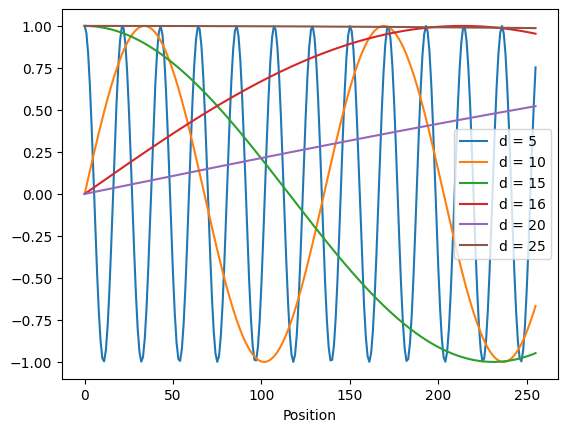

In [3]:
# TODO: Run this cell to test your implementation
input_ids = torch.zeros(64, 256, 30)

spe = SinusoidalPositionalEmbedding(num_positions=256, embedding_dim=30)
# Note that the forward takes the input shape as the argument
out = spe(input_ids.shape)

# Plot some dimensions to compare
import matplotlib.pyplot as plt
inds_to_plot = [5, 10, 15, 16, 20, 25]
for i in inds_to_plot:
    plt.plot(out[:, i], label=f"d = {i}")
plt.xlabel("Position")
plt.legend()
plt.show()

## 2. Complete the transformer model class
Typically for NLP applications, when we do predictions on an entire sequence (e.g. sentence classification), we prepend a special `[CLS]` token to the text that represents we want to make classification predictions on its outputs. We adapt a similar thing here with this time-series classification problem by replacing the first sequence element with a vector that represents that we want to perform classification on its outputs.

If you are building a transfomer, some of the important hyperparameters to consider are:
- Embedding dimension / feature dimension, $D$
- Dimension of the feedforward network, $D_{FFN}$
- Number of attention heads, $H$ ($A$ in literature too, as $H$ can represent hidden size)
- Sequence length, $N$
- Number of stacked transformer layers, $L$

In the `__init__`:
- Create an input `nn.Linear` layer to transform from 30 input features to $D=128$ features
- Create a position embedding layer from the class above with $N=256$ position and $D=128$ features
- Create a `nn.TransformerEncoderLayer` ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html)) and add in the relevant arguments for the parameters below. Leave the other arguments already specified alone, they are sensible defaults for transformers to start with. 
    - $D = 128$
    - $H = 4$
    - $D_{FFN} = 2 * D$
- Create the encoder stack with $L = 3$ layers using the `nn.TransformerEncoder` class ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder)). Pass in the encoder layer you created.

In the `forward`:
- Apply the input layer to the transform the inputs to the same dimension as the transformer encoder
- Generate the position embeddings and add them to the transformed inputs
- Pass through the transformer encoder


In [15]:
class TransformerModel(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Create the input linear and position embedding layers
        self.d_model = None
        self.position_embed = None
        self.input_transform = None
        #####

        self.encoder_layer = nn.TransformerEncoderLayer(
        # TODO: Add in 3 arguments here
            
        #####
            dropout=0.1,
            activation="gelu",
            batch_first=True,
            norm_first=True
        )

        # TODO: Create the transformer encoder layer stack
        self.encoder = None
        #####

        # Other layers for the model, leave these as is
        self.cls = nn.Parameter(torch.randn(30), requires_grad=True)
        self.layer_norm = nn.LayerNorm(self.d_model)
        self.classifier = nn.Linear(self.d_model, 1)
    
    def forward(self, x):
        # Replace first sequence element with cls token
        x[:, 0, :] = self.cls

        # TODO: Pass x through the input linear layer
        
     
        # TODO: Generate the position embedding from the input shape
        # and add it to the transformed inputs
        
        # TODO: Pass the inputs through the encoder layers
        
        #####

        # Rest of the layers, leave as is
        x = self.layer_norm(x)
        x = x[:, 0, :].reshape(-1, self.d_model)  # Predict only on cls token
        x = self.classifier(x)
        x = torch.flatten(x)
        return x

In [16]:
# TODO: Run this cell to test your implementation. The outputs should be size 64
model = TransformerModel()
x = torch.randn(64, 256, 30)
y = model(x)
y.shape

torch.Size([64])

## 3. Add in GPU support to the training loop

In PyTorch, you need to manually specify which "device" certain tensors and the model live on. By default, the device of a tensor is `'cpu'` but if we want to take advantage of running code on a CUDA-capable Nvidia GPU, we need to specicify the device as `'cuda'`. Note the first line in the `train` and `test` function specifies the device will be GPU if PyTorch can detect that there is one available, otherwise it defaults to CPU.

As long as the model is defined as a `nn.Module` subclass, this is accomplished by putting `model = model.to(device)` to move the entire model's parameters. Occasionally, if intermediate arrays are created during processing (such as in the sinusoidal position embeddings forward method), you may need to manually do some device manipulation in the code. This can often be a reason for device errors. 

If the model is on the GPU, then all the input arrays need to also be the GPU. In addition, any outputs a model produces will also be on GPU. We can move tensors by writing `x = x.to(device)`. We sometimes need to move outputs specifically back to CPU to compute metrics. We can do this by calling `x = x.cpu()`. PyTorch is pretty good at telling you when there are two devices involved in some kind of computation, or if numpy cannot handle arrays on a GPU. 


In [18]:
# TODO: Run this cell to define the train function

def train(model, train_loader, loss_fn, optimizer, epoch=-1):
    """
    Trains a model for one epoch (one pass through the entire training data).

    :param model: PyTorch model
    :param train_loader: PyTorch Dataloader for training data
    :param loss_fn: PyTorch loss function
    :param optimizer: PyTorch optimizer, initialized with model parameters
    :kwarg epoch: Integer epoch to use when printing loss and accuracy
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    total_loss = 0
    all_predictions = []
    all_targets = []

    model.train()  # Set model in training mode
    model = model.to(device)  # Put model on GPU (if available)
    for i, (inputs, targets) in enumerate(train_loader):  # 1. Fetch next batch of data
        
        # TODO: Put the inputs and targets onto the device


        #####
        
        optimizer.zero_grad()  # 2. Zero parameter gradients
        outputs = model(inputs)  # 3. Compute model outputs
        loss = loss_fn(outputs, targets)  # 4. Compute loss between outputs and targets
        loss.backward()  # 5. Backpropagation for parameter gradients
        optimizer.step()  # 6. Gradient descent step

        # Track some values to compute statistics
        total_loss += loss.item()

        # TODO: Move outputs and targets back to CPU


        #####

        preds = torch.round(torch.sigmoid(outputs))  # Binary classification, round sigmoid of logits
        all_predictions.extend(preds.tolist())
        all_targets.extend(targets.tolist())

        # Print some statistics every 100 batches
        if i % 100 == 0:
            running_loss = total_loss / (i + 1)
            print(f"Epoch {epoch + 1}, batch {i + 1}: loss = {running_loss:.2f}")
     
    acc = accuracy_score(all_targets, all_predictions)

    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average train loss = {total_loss / len(train_loader):.2f}, average train accuracy = {acc * 100:.3f}%")

In [19]:
# TODO: Run this cell to define the test function

def test(model, test_loader, loss_fn, epoch=-1):
    """
    Tests a model for one epoch of test data.

    Note:
        In testing and evaluation, we do not perform gradient descent optimization, so steps 2, 5, and 6 are not needed.
        For performance, we also tell torch not to track gradients by using the `with torch.no_grad()` context.

    :param model: PyTorch model
    :param test_loader: PyTorch Dataloader for test data
    :param loss_fn: PyTorch loss function
    :kwarg epoch: Integer epoch to use when printing loss and accuracy
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    total_loss = 0
    all_predictions = []
    all_targets = []

    model.eval()  # Set model in evaluation mode
    model = model.to(device)
    for i, (inputs, targets) in enumerate(test_loader):  # 1. Fetch next batch of data
        # TODO: Put the inputs and targets onto the device


        #####

        with torch.no_grad():
            outputs = model(inputs)  # 3. Compute model outputs
            loss = loss_fn(outputs, targets)  # 4. Compute loss between outputs and targets

            # Track some values to compute statistics
            total_loss += loss.item()

            # TODO: Move outputs and targets back to CPU


            #####
            preds = torch.round(torch.sigmoid(outputs))  # Binary classification, round sigmoid of logits
            all_predictions.extend(preds.tolist())
            all_targets.extend(targets.tolist())
      
    acc = accuracy_score(all_targets, all_predictions)

    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average test loss = {total_loss / len(test_loader):.2f}, average test accuracy = {acc * 100:.3f}%")

## 4. Train the transformer for 5 epochs (optional)

Because the dataset on LEARN is a fairly large file (600 MB), you may not want to download it and upload it to Google Colab, so this is optional to complete, or you can do it on your own time to verify your model trains.

### Load and preprocess the data

In [20]:
with open("transformer-data.pkl", "rb") as f:  # May need to change path to the data in Colab
    data = pickle.load(f)

train_X = data["train_X"]
train_Y = data["train_Y"]
test_X = data["test_X"]
test_Y = data["test_Y"]

In [21]:
class FoGDataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        """
        Parameters:
        -----------
        data_x: np.ndarray of shape (num_samples, window_size, num_features) which contains data features for FoG
        data_y: np.ndarray of shape (num_samples, window_size) which contains binary labels for FoG
        """
        super().__init__()
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, index):
        """Returns tuple of (data, label) at index"""
        inputs = self.data_x[index, :, :]
        y = self.data_y[index, :]
        labels = np.any(y == 1)
        return inputs.astype(np.float32), labels.astype(np.float32)

In [22]:
train_dataset = FoGDataset(train_X, train_Y)
test_dataset = FoGDataset(test_X, test_Y)

BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Train the model

In [23]:
# TODO: Run this cell to train the Transformer for 5 epochs
# Note that the model overfits after 1 epoch as the test accuracy is maximal then. There aren't many examples in this dataset.
model = TransformerModel()
optimizer = optim.Adam(model.parameters(), lr=5e-4)
loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(5):
    train(model, train_loader, loss_fn, optimizer, epoch)
    test(model, test_loader, loss_fn, epoch)

Epoch 1, batch 1: loss = 0.75
Epoch 1, batch 101: loss = 0.58
Epoch 1 done. Average train loss = 0.53, average train accuracy = 71.950%
Epoch 1 done. Average test loss = 0.59, average test accuracy = 68.600%
Epoch 2, batch 1: loss = 0.32
Epoch 2, batch 101: loss = 0.39
Epoch 2 done. Average train loss = 0.38, average train accuracy = 83.230%
Epoch 2 done. Average test loss = 0.63, average test accuracy = 68.100%
Epoch 3, batch 1: loss = 0.37
Epoch 3, batch 101: loss = 0.33
Epoch 3 done. Average train loss = 0.33, average train accuracy = 85.950%
Epoch 3 done. Average test loss = 0.70, average test accuracy = 67.900%
Epoch 4, batch 1: loss = 0.17
Epoch 4, batch 101: loss = 0.30
Epoch 4 done. Average train loss = 0.30, average train accuracy = 87.250%
Epoch 4 done. Average test loss = 0.66, average test accuracy = 68.300%
Epoch 5, batch 1: loss = 0.22
Epoch 5, batch 101: loss = 0.26
Epoch 5 done. Average train loss = 0.27, average train accuracy = 88.820%
Epoch 5 done. Average test loss 

# 5. HuggingFace Transformers Example (optional)
Running this example is optional, there's no really new code for you to write, but it gives a good starting point if you're ever thinking of using transformers for NLP.

The following example is adapted from [this tutorial](https://huggingface.co/docs/transformers/training) to run with a smaller model. In the example, you will fine-tune a small BERT model on the Yelp Review dataset.

For any NLP applications, the Hugging Face transformers library is the way to go. They have many pre-trained models that you can fine-tune on specific tasks. You can search pre-trained models in the [Hugging Face Hub](https://huggingface.co/docs/hub/index). They also have support for tokenizers, data processing, NLP metrics, and more. 

The typical NLP workflow looks something like this:
1. Obtain text dataset
2. Convert text dataset into tokens (integer ids) using a tokenizer
3. Obtain a pre-trained model for your task (sequence classfication, token classification, question answering, etc.)
4. Run fine-tuning using your model and tokenized dataset
5. Evaluate your fine-tuned model

In [ ]:
# Install HuggingFace packages into Google Colab
# !pip install transformers evaluate datasets

## Pre-process dataset

In [5]:
from datasets import load_dataset
from transformers import AutoTokenizer

dataset = load_dataset("yelp_review_full")

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset yelp_review_full downloaded and prepared to /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# View an example
dataset["train"][100]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

In [7]:
# Load tokenizer and process the text data
hf_model_path = "prajjwal1/bert-small"  # The path for the BERT small model

tokenizer = AutoTokenizer.from_pretrained(hf_model_path)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

  0%|          | 0/650 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [8]:
# Create smaller test and train datasets
train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(10_000))
test_dataset = tokenized_dataset["test"].shuffle(seed=42).select(range(1000))

## Setup models

In [9]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np
import torch

# Load the model from a pre-trained checkpoint and setup for text classification
model = AutoModelForSequenceClassification.from_pretrained(hf_model_path, num_labels=5)

2023-03-16 02:09:49.008139: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-16 02:09:49.008269: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-16 02:09:49.008289: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertForSequenceCla

Note that you can specify other hyperparmeters like optimizer, learning rate, batch size, number of epochs, etc. in the `TrainingArguments`. See the [documentation](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) for more information.

In [10]:
BATCH_SIZE = 32

# Setup training arguments
training_args = TrainingArguments(
    output_dir="test_trainer",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=10
)

In [11]:
# Define how metrics will be computed
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [12]:
# Setup trainer for the PyTorch model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [13]:
# Run the training
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10000
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1570
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsquee

Epoch,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running

TrainOutput(global_step=1570, training_loss=0.674260434679165, metrics={'train_runtime': 325.7818, 'train_samples_per_second': 306.954, 'train_steps_per_second': 4.819, 'total_flos': 988859980800000.0, 'train_loss': 0.674260434679165, 'epoch': 10.0})

Note that the model overfits as the validation loss and accuracy are best around epoch 2-3, but this is because our training data is small. 

## Test on an example

In [14]:
# Same example as before
test_text = dataset["train"][100]["text"]
test_label = dataset["train"][100]["label"]

input = tokenizer(test_text, padding="max_length", truncation=True, max_length=128)
input = {k: torch.as_tensor(v).reshape(1, -1).cuda() for k, v in input.items()}

In [15]:
model = trainer.model

In [16]:
output = model(**input)
prediction = torch.argmax(output.logits)

In [17]:
prediction, test_label

(tensor(0, device='cuda:0'), 0)